In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
import torch
import gpytorch
from math import pi

import matplotlib.pyplot as plt
from util import *

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

torch.set_default_tensor_type(torch.DoubleTensor)

name = 'GP Quadratic'

train_x = torch.tensor([[1/13,1/6],[1/13,3/8],[1/13,7/12],[1/13,19/24],[1/13,1],
                        [5/13,1/6],[5/13,3/8],[5/13,7/12],[5/13,19/24],[5/13,1],
                        [9/13,1/6],[9/13,3/8],[9/13,7/12],[9/13,19/24],[9/13,1],
                        [1,1/6],[1,3/8],[1,7/12],[1,19/24],[1,1]], dtype=torch.double)

train_y = torch.tensor([0,2,2,1,2,2,5,5,4,4,8,6,7,10,6,6,9,9,8,8], dtype=torch.double)


x1_range = torch.linspace(0, 1, 53)
x2_range = torch.linspace(0, 1, 97)
X1, X2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
xs = torch.vstack((X1.flatten(), X2.flatten())).transpose(-1, -2)

In [2]:
class QuadraticMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(
            name="second0", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
        )
        self.register_parameter(
            name="first0", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
        )

        self.register_parameter(
            name="second1", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
        )
        self.register_parameter(
            name="first1", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
        )
        self.register_parameter(
            name="mutual", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
        )

        if bias:
            self.register_parameter(
                name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
            )
        else:
            self.bias = None

    def forward(self, x):
        res = (
            x[:, 0].pow(2) * self.second0.squeeze(-1)
            + x[:, 0] * self.first0.squeeze(-1)
            + x[:, 1].pow(2) * self.second1.squeeze(-1)
            + x[:, 1] * self.first1.squeeze(-1)
            + x[:, 0] * x[:, 1] * self.mutual.squeeze(-1)
        )
        if self.bias is not None:
            res = res + self.bias
        return res

In [3]:
class QuadraticMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = QuadraticMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
noise = 0.05

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = QuadraticMeanGPModel(train_x, train_y, likelihood)


model.likelihood.noise = noise

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [5]:
losses = []
first0s = []
second0s = []
first1s = []
second1s = []
mutuals = []
biases = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    first0s.append(model.mean_module.first0.item())
    second0s.append(model.mean_module.second0.item())
    first1s.append(model.mean_module.first1.item())
    second1s.append(model.mean_module.second1.item())
    mutuals.append(model.mean_module.mutual.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

d:\HybridOpt\.conda\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

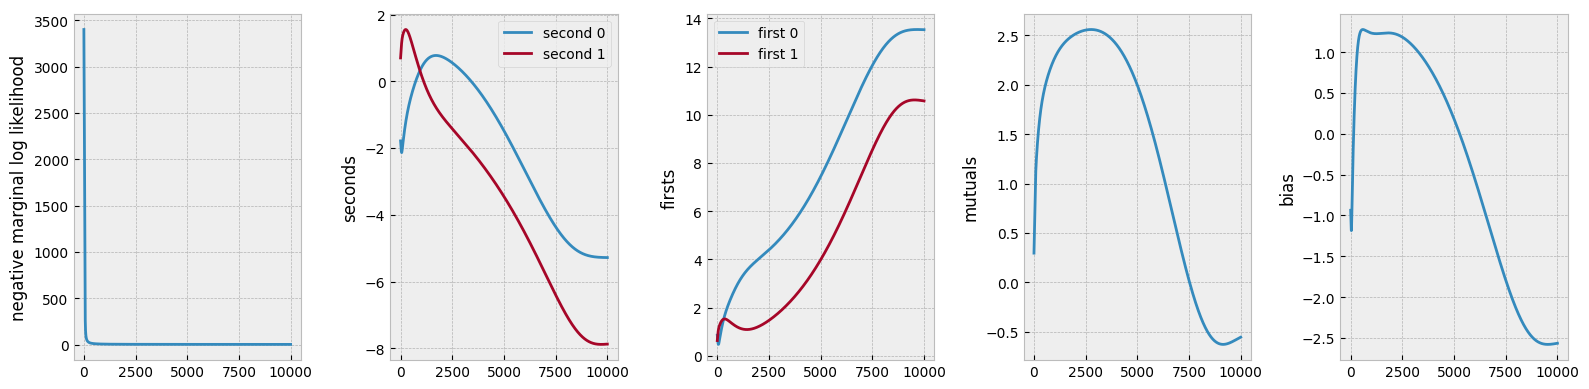

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(second0s, label="second 0")  
ax[1].plot(second1s, label="second 1")  
ax[1].set_ylabel("seconds")
ax[1].legend()

ax[2].plot(first0s, label="first 0")  
ax[2].plot(first1s, label="first 1")  
ax[2].set_ylabel("firsts")
ax[2].legend()

ax[3].plot(mutuals)
ax[3].set_ylabel("mutuals")

ax[4].plot(biases)
ax[4].set_ylabel("bias")

plt.tight_layout()

In [7]:
print(model.covar_module.base_kernel.lengthscale)
print(model.likelihood.noise)

tensor([[0.1032, 0.0887]], grad_fn=<SoftplusBackward0>)
tensor([0.0001], grad_fn=<AddBackward0>)


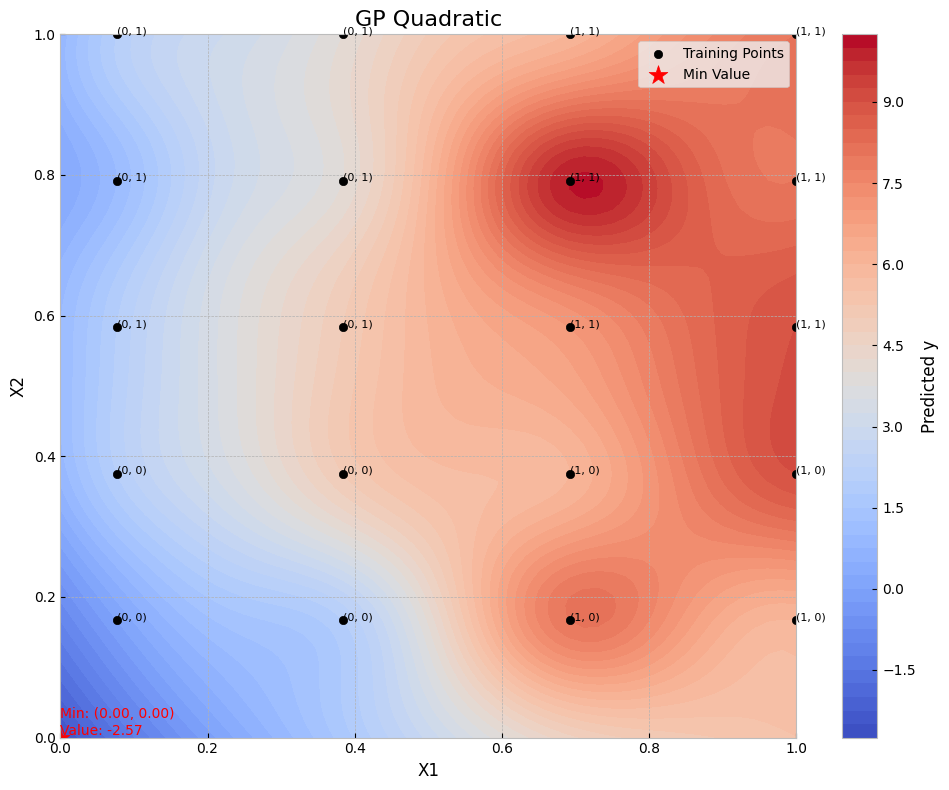

In [8]:
visualize_2d_contour(name, model, likelihood, train_x, X1, X2, xs)

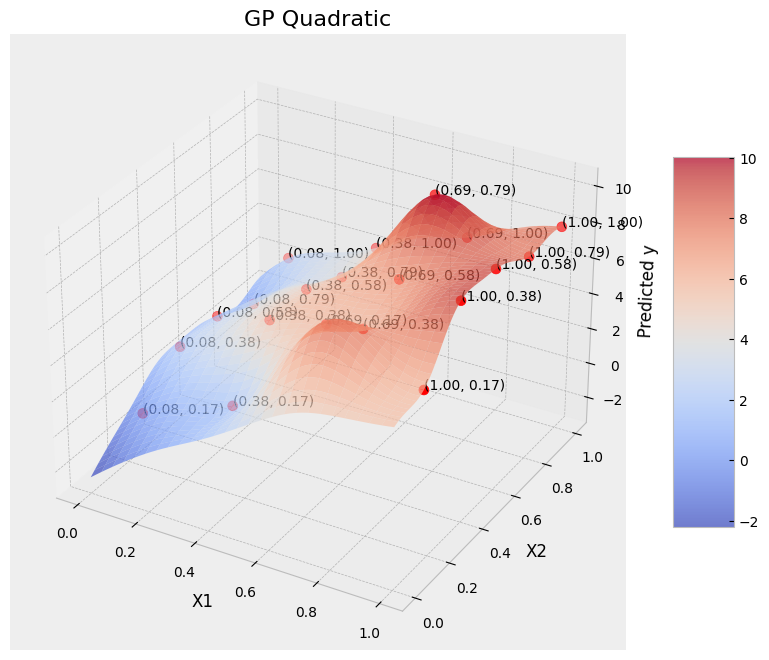

In [9]:
visualize_gp_belief(name, model, likelihood, train_x, train_y, X1, X2, xs)